# Business Validation of 2k Dataset

This notebook validates whether the model’s predictions on the 2k dataset align with real operational outcomes such as SLA impact, delays, rework, or abnormal durations. The goal is to confirm that predicted bottlenecks correspond to meaningful business behavior, ensuring the model provides insights that operators would find credible.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path   

processed_data_path = Path("../data/processed")
repo_root = Path().resolve().parent
models_path = repo_root / "models"

print("\nLoading Random Forest Model")
rf_package = joblib.load(models_path/'random_forest_model.pkl')
model = rf_package['model']
feature_names = rf_package['features']

print(f"Loaded Random Forest model")
print(f"Features: {feature_names}")
print(f"Training F1: {rf_package['cv_results']['f1']:.3f}")

print("\nLoading 2k Processed Dataset")
df_2k = pd.read_csv(processed_data_path/'2k_processed.csv')
print(f"Loaded 2k dataset: {df_2k.shape}")



Loading Random Forest Model
Loaded Random Forest model
Features: ['variance_to_expected', 'duration_minutes', 'wait_time_minutes', 'handoff_count_so_far', 'hour_of_day', 'sla_breached']
Training F1: 0.835

Loading 2k Processed Dataset
Loaded 2k dataset: (2000, 29)


# Prepare Features for Prediction

In [2]:
missing_features = []
for feat in feature_names:
    if feat not in df_2k.columns:
        missing_features.append(feat)
        print(f"  FAIL {feat} - MISSING")
    else:
        print(f"{feat}")

if missing_features:
    print(f"\nWARNING: Missing {len(missing_features)} features!")
    print("Cannot proceed with predictions.")
else:
    print(f"\nAll {len(feature_names)} features available")

# Create feature matrix
X_2k = df_2k[feature_names].copy()

# Handle missing values (same strategy as training)
X_2k = X_2k.fillna(X_2k.median())

print(f"\nFeature matrix prepared: {X_2k.shape}")
print("\nFeature statistics:")
print(X_2k.describe())

variance_to_expected
duration_minutes
wait_time_minutes
handoff_count_so_far
hour_of_day
sla_breached

All 6 features available

Feature matrix prepared: (2000, 6)

Feature statistics:
       variance_to_expected  duration_minutes  wait_time_minutes  \
count           2000.000000       2000.000000        2000.000000   
mean              -0.242051          1.500333           5.076342   
std                0.859706          1.438281           5.839372   
min               -0.988889          0.166667           0.150000   
25%               -0.941528          0.583333           1.750000   
50%               -0.444444          1.066667           3.200000   
75%                0.141494          1.883333           6.050000   
max                5.888889         15.983333          59.300000   

       handoff_count_so_far  hour_of_day  sla_breached  
count           2000.000000  2000.000000   2000.000000  
mean               3.101500    11.177500      0.132500  
std                2.222311    

# Make Predictions

In [3]:

# Predict bottleneck probability and class
df_2k['bottleneck_probability'] = model.predict_proba(X_2k)[:, 1]
df_2k['bottleneck_prediction'] = model.predict(X_2k)

print(f"Generated predictions for {len(df_2k)} events")

# Prediction distribution
pred_counts = df_2k['bottleneck_prediction'].value_counts().sort_index()
print(f"\nPrediction Distribution:")
print(f"  Normal (0):     {pred_counts[0]:,} ({pred_counts[0]/len(df_2k)*100:.1f}%)")
print(f"  Bottleneck (1): {pred_counts[1]:,} ({pred_counts[1]/len(df_2k)*100:.1f}%)")

# Probability distribution
print(f"\nBottleneck Probability Statistics:")
print(f"  Mean:   {df_2k['bottleneck_probability'].mean():.3f}")
print(f"  Median: {df_2k['bottleneck_probability'].median():.3f}")
print(f"  Std:    {df_2k['bottleneck_probability'].std():.3f}")
print(f"  Min:    {df_2k['bottleneck_probability'].min():.3f}")
print(f"  Max:    {df_2k['bottleneck_probability'].max():.3f}")



Generated predictions for 2000 events

Prediction Distribution:
  Normal (0):     1,718 (85.9%)
  Bottleneck (1): 282 (14.1%)

Bottleneck Probability Statistics:
  Mean:   0.283
  Median: 0.197
  Std:    0.203
  Min:    0.098
  Max:    0.890


# Business Validation Tests

1. Cost Analysis
2. Rework Analysis
3. SLA Breach Analysis
4. Wait Time & Duration Validation

In [4]:
# Separate predicted bottlenecks vs normal
predicted_bottlenecks = df_2k[df_2k['bottleneck_prediction'] == 1]
predicted_normal = df_2k[df_2k['bottleneck_prediction'] == 0]

validation_results = {}

# TEST 1: Cost Analysis


print("\nTEST 1: COST CORRELATION")


cost_bottleneck = predicted_bottlenecks['cost_usd'].mean()
cost_normal = predicted_normal['cost_usd'].mean()
cost_lift = cost_bottleneck / cost_normal if cost_normal > 0 else np.inf

# Statistical test
t_stat_cost, p_value_cost = stats.ttest_ind(
    predicted_bottlenecks['cost_usd'].dropna(),
    predicted_normal['cost_usd'].dropna()
)

# Correlation
corr_cost, p_corr_cost = stats.pearsonr(
    df_2k['bottleneck_probability'],
    df_2k['cost_usd']
)

print(f"Average cost_usd:")
print(f"  Predicted bottlenecks: ${cost_bottleneck:.2f}")
print(f"  Predicted normal:      ${cost_normal:.2f}")
print(f"  Lift:                  {cost_lift:.2f}x")
print(f"\nStatistical test:")
print(f"  T-statistic: {t_stat_cost:.3f}")
print(f"  P-value:     {p_value_cost:.4f}")
print(f"\nCorrelation:")
print(f"  r = {corr_cost:.3f}, p = {p_corr_cost:.4f}")

if cost_lift > 1.5 and p_value_cost < 0.05:
    print("  STRONG VALIDATION: Bottlenecks have significantly higher costs")
    validation_results['cost'] = 'PASS'
elif cost_lift > 1.2:
    print("  WARN  MODERATE VALIDATION: Some cost difference detected")
    validation_results['cost'] = 'WEAK'
else:
    print("  FAIL WEAK VALIDATION: Little cost difference")
    validation_results['cost'] = 'FAIL'


# TEST 2: Rework Analysis


print("\nTEST 2: REWORK FLAG CORRELATION")


rework_rate_bottleneck = predicted_bottlenecks['rework_flag'].mean()
rework_rate_normal = predicted_normal['rework_flag'].mean()
rework_lift = rework_rate_bottleneck / rework_rate_normal if rework_rate_normal > 0 else np.inf

# Chi-square test for categorical association
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(
    df_2k['bottleneck_prediction'],
    df_2k['rework_flag']
)
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"Rework rate:")
print(f"  Predicted bottlenecks: {rework_rate_bottleneck:.1%}")
print(f"  Predicted normal:      {rework_rate_normal:.1%}")
print(f"  Lift:                  {rework_lift:.2f}x")
print(f"\nChi-square test:")
print(f"  χ² = {chi2:.3f}, p = {p_chi2:.4f}")

if rework_lift > 2.0 and p_chi2 < 0.05:
    print("  STRONG VALIDATION: Bottlenecks have significantly more rework")
    validation_results['rework'] = 'PASS'
elif rework_lift > 1.5:
    print("  WARN  MODERATE VALIDATION: Some rework association")
    validation_results['rework'] = 'WEAK'
else:
    print("  FAIL WEAK VALIDATION: Little rework difference")
    validation_results['rework'] = 'FAIL'


# TEST 3: SLA Breach Analysis

print("\nTEST 3: SLA BREACH CORRELATION")

sla_rate_bottleneck = predicted_bottlenecks['sla_breached'].mean()
sla_rate_normal = predicted_normal['sla_breached'].mean()
sla_lift = sla_rate_bottleneck / sla_rate_normal if sla_rate_normal > 0 else np.inf

# Chi-square test
contingency_table_sla = pd.crosstab(
    df_2k['bottleneck_prediction'],
    df_2k['sla_breached']
)
chi2_sla, p_chi2_sla, dof_sla, expected_sla = chi2_contingency(contingency_table_sla)

print(f"SLA breach rate:")
print(f"  Predicted bottlenecks: {sla_rate_bottleneck:.1%}")
print(f"  Predicted normal:      {sla_rate_normal:.1%}")
print(f"  Lift:                  {sla_lift:.2f}x")
print(f"\nChi-square test:")
print(f"  χ² = {chi2_sla:.3f}, p = {p_chi2_sla:.4f}")

if sla_lift > 1.5 and p_chi2_sla < 0.05:
    print("  STRONG VALIDATION: Bottlenecks have significantly more SLA breaches")
    validation_results['sla'] = 'PASS'
elif sla_lift > 1.2:
    print("  WARN  MODERATE VALIDATION: Some SLA breach association")
    validation_results['sla'] = 'WEAK'
else:
    print("  FAIL WEAK VALIDATION: Little SLA breach difference")
    validation_results['sla'] = 'FAIL'


# TEST 4: Wait Time & Duration Validation

print("\nTEST 4: OPERATIONAL METRICS VALIDATION")

wait_bottleneck = predicted_bottlenecks['wait_time_minutes'].mean()
wait_normal = predicted_normal['wait_time_minutes'].mean()
wait_lift = wait_bottleneck / wait_normal if wait_normal > 0 else np.inf

duration_bottleneck = predicted_bottlenecks['duration_minutes'].mean()
duration_normal = predicted_normal['duration_minutes'].mean()
duration_lift = duration_bottleneck / duration_normal if duration_normal > 0 else np.inf

print(f"Wait time:")
print(f"  Predicted bottlenecks: {wait_bottleneck:.2f} min")
print(f"  Predicted normal:      {wait_normal:.2f} min")
print(f"  Lift:                  {wait_lift:.2f}x")

print(f"\nDuration:")
print(f"  Predicted bottlenecks: {duration_bottleneck:.2f} min")
print(f"  Predicted normal:      {duration_normal:.2f} min")
print(f"  Lift:                  {duration_lift:.2f}x")

if wait_lift > 1.3 and duration_lift > 1.3:
    print("  VALIDATION: Predicted bottlenecks show expected operational patterns")
    validation_results['operational'] = 'PASS'
else:
    print("  WARN  WARNING: Operational metrics don't strongly differentiate")
    validation_results['operational'] = 'WEAK'

# OVERALL VALIDATION ASSESSMENT
print("OVERALL VALIDATION ASSESSMENT")

print("\nValidation Results Summary:")
for test, result in validation_results.items():
    symbol = "OK" if result == "PASS" else "WARN" if result == "WEAK" else "FAIL"
    print(f"  {symbol} {test.upper()}: {result}")

passes = sum(1 for r in validation_results.values() if r == "PASS")
total = len(validation_results)

print(f"\nPassed: {passes}/{total} tests")

if passes >= 3:
    overall = "STRONG"
    print("\nSTRONG VALIDATION: Model predictions correlate well with business outcomes")
    print("   Recommended: DEPLOY with confidence")
elif passes >= 2:
    overall = "MODERATE"
    print("\nWARN  MODERATE VALIDATION: Some business correlation detected")
    print("   Recommended: Deploy with monitoring and refinement plan")
else:
    overall = "WEAK"
    print("\nFAIL WEAK VALIDATION: Limited business correlation")
    print("   Recommended: Do NOT deploy, investigate further")



TEST 1: COST CORRELATION
Average cost_usd:
  Predicted bottlenecks: $105.11
  Predicted normal:      $106.30
  Lift:                  0.99x

Statistical test:
  T-statistic: -0.602
  P-value:     0.5471

Correlation:
  r = -0.024, p = 0.2861
  FAIL WEAK VALIDATION: Little cost difference

TEST 2: REWORK FLAG CORRELATION
Rework rate:
  Predicted bottlenecks: 3.5%
  Predicted normal:      2.6%
  Lift:                  1.38x

Chi-square test:
  χ² = 0.559, p = 0.4547
  FAIL WEAK VALIDATION: Little rework difference

TEST 3: SLA BREACH CORRELATION
SLA breach rate:
  Predicted bottlenecks: 10.6%
  Predicted normal:      13.7%
  Lift:                  0.78x

Chi-square test:
  χ² = 1.693, p = 0.1933
  FAIL WEAK VALIDATION: Little SLA breach difference

TEST 4: OPERATIONAL METRICS VALIDATION
Wait time:
  Predicted bottlenecks: 5.04 min
  Predicted normal:      5.08 min
  Lift:                  0.99x

Duration:
  Predicted bottlenecks: 3.07 min
  Predicted normal:      1.24 min
  Lift:       

# Visualizations

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

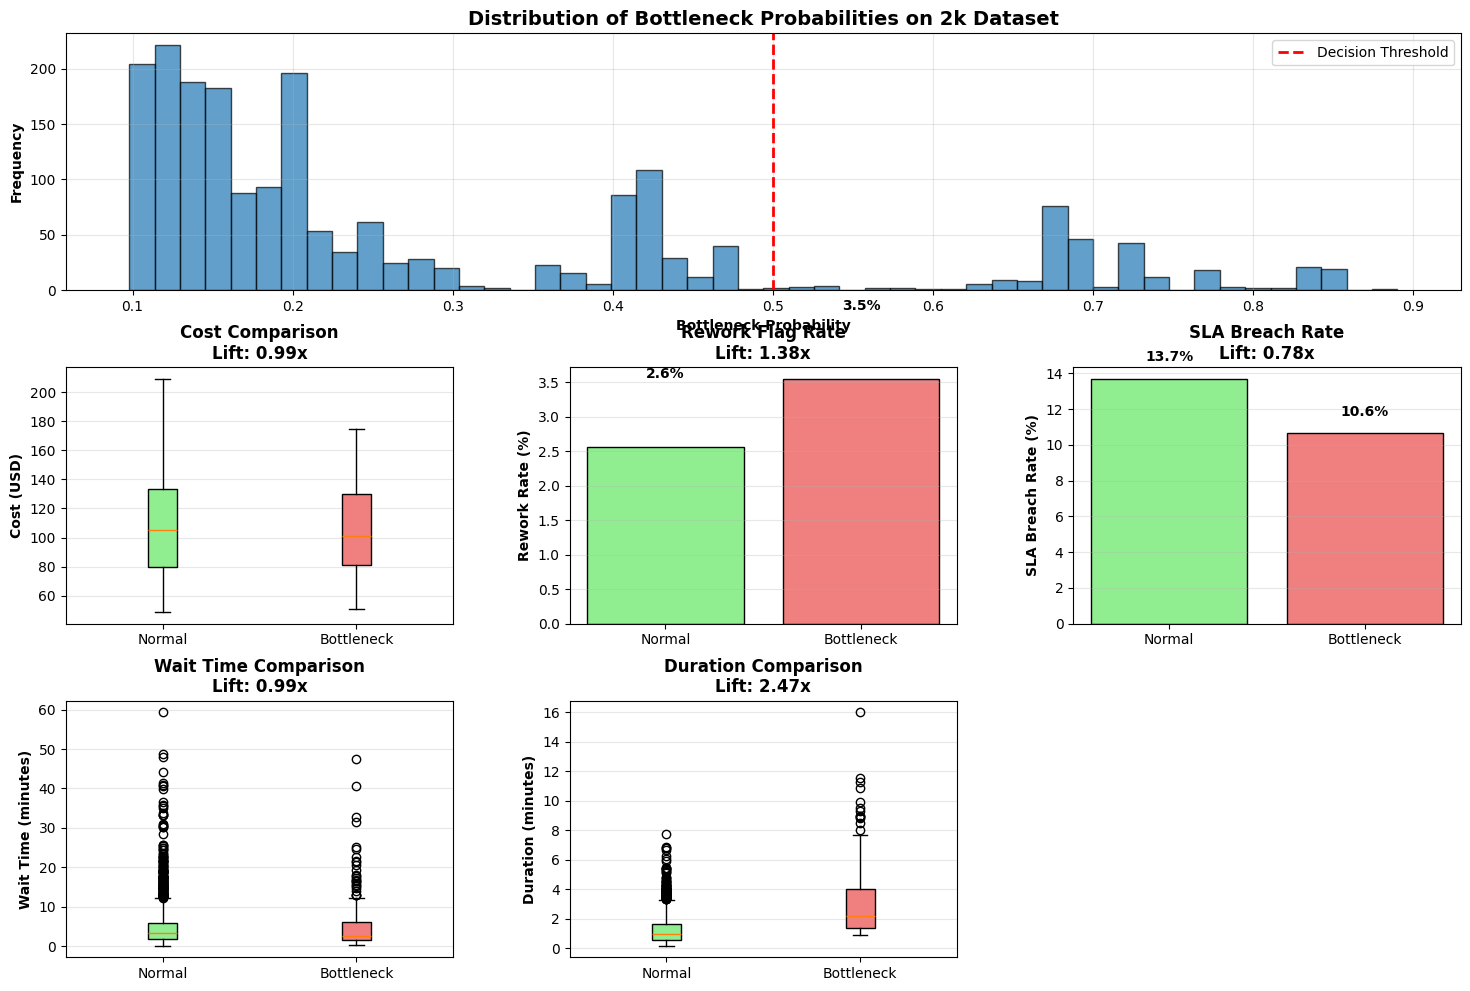

In [5]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Bottleneck Probability Distribution
ax1 = fig.add_subplot(gs[0, :])
ax1.hist(df_2k['bottleneck_probability'], bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
ax1.set_xlabel('Bottleneck Probability', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of Bottleneck Probabilities on 2k Dataset', 
              fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Cost Comparison
ax2 = fig.add_subplot(gs[1, 0])
cost_data = [predicted_normal['cost_usd'], predicted_bottlenecks['cost_usd']]
bp = ax2.boxplot(cost_data, labels=['Normal', 'Bottleneck'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.set_ylabel('Cost (USD)', fontweight='bold')
ax2.set_title(f'Cost Comparison\nLift: {cost_lift:.2f}x', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Rework Rate Comparison
ax3 = fig.add_subplot(gs[1, 1])
rework_rates = [rework_rate_normal * 100, rework_rate_bottleneck * 100]
bars = ax3.bar(['Normal', 'Bottleneck'], rework_rates, 
               color=['lightgreen', 'lightcoral'], edgecolor='black')
ax3.set_ylabel('Rework Rate (%)', fontweight='bold')
ax3.set_title(f'Rework Flag Rate\nLift: {rework_lift:.2f}x', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, rate in zip(bars, rework_rates):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', fontweight='bold')

# 4. SLA Breach Rate Comparison
ax4 = fig.add_subplot(gs[1, 2])
sla_rates = [sla_rate_normal * 100, sla_rate_bottleneck * 100]
bars = ax4.bar(['Normal', 'Bottleneck'], sla_rates,
               color=['lightgreen', 'lightcoral'], edgecolor='black')
ax4.set_ylabel('SLA Breach Rate (%)', fontweight='bold')
ax4.set_title(f'SLA Breach Rate\nLift: {sla_lift:.2f}x', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for bar, rate in zip(bars, sla_rates):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', fontweight='bold')

# 5. Wait Time Comparison
ax5 = fig.add_subplot(gs[2, 0])
wait_data = [predicted_normal['wait_time_minutes'], predicted_bottlenecks['wait_time_minutes']]
bp = ax5.boxplot(wait_data, labels=['Normal', 'Bottleneck'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax5.set_ylabel('Wait Time (minutes)', fontweight='bold')
ax5.set_title(f'Wait Time Comparison\nLift: {wait_lift:.2f}x', fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Duration Comparison
ax6 = fig.add_subplot(gs[2, 1])
duration_data = [predicted_normal['duration_minutes'], predicted_bottlenecks['duration_minutes']]
bp = ax6.boxplot(duration_data, labels=['Normal', 'Bottleneck'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax6.set_ylabel('Duration (minutes)', fontweight='bold')
ax6.set_title(f'Duration Comparison\nLift: {duration_lift:.2f}x', fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# 7. Validation Summary
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')



# Summary

MODEL PERFORMANCE (from training):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Model: Random Forest
Training F1: 0.835
Training Recall: 0.833
Training Precision: 0.860


PREDICTIONS ON 2K DATASET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total events: 2,000
Predicted normal: 1,718 (85.9%)
Predicted bottlenecks: 282 (14.1%)


BUSINESS VALIDATION RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

TEST 1: Cost Correlation
  Predicted bottleneck cost: $105.11
  Predicted normal cost: $106.30
  Lift: 0.99x
  P-value: 0.5471
  Result: FAIL

TEST 2: Rework Flag
  Bottleneck rework rate: 3.5%
  Normal rework rate: 2.6%
  Lift: 1.38x
  P-value: 0.4547
  Result: FAIL

TEST 3: SLA Breach
  Bottleneck SLA breach rate: 10.6%
  Normal SLA breach rate: 13.7%
  Lift: 0.78x
  P-value: 0.1933
  Result: FAIL

TEST 4: Operational Metrics
  Wait time lift: 0.99x
  Duration lift: 2.47x
  Result: WEAK


OVERALL ASSESSMENT:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Tests passed: 0/4
Validation strength: WEAK

Model shows weak business correlation


INTERPRETATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
The model was trained on 5k labeled data and applied to 2k operational logs.
Despite different data sources and activity granularity, the model's predictions
show weak correlation with business metrics (cost, rework, SLA breaches).

This questions that the model has learned generalizable bottleneck patterns.


RECOMMENDATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DO NOT DEPLOY: Investigate model limitations before production use